In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

In [1]:
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
import os
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
import os

import spacy
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import pickle
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import transformers

from spacy.lang.en import English
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()
en = English()

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split


c:\Users\nikhi\Desktop\SEM III\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.5/42.8 MB 15.9 MB/s eta 0:00:03
     - -------------------------------------- 2.0/42.8 MB 18.2 MB/s eta 0:00:03
     -- ------------------------------------- 3.2/42.8 MB 22.5 MB/s eta 0:00:02
     ---- ----------------------------------- 4.7/42.8 MB 25.0 MB/s eta 0:00:02
     ----- ---------------------------------- 6.0/42.8 MB 25.4 MB/s eta 0:00:02
     ------- -------------------------------- 7.6/42.8 MB 26.9 MB/s eta 0:00:02
     -------- ------------------------------- 8.6/42.8 MB 26.2 MB/s eta 0:00:02
     -------- ------------------------------- 9.2/42.8 MB 25.5 MB/s eta 0:00:02
     --------- ----------------------------- 10.8/42.8 MB 27.3 MB/s eta 0:00:02
     ---------- ---------------------------- 11.9/42.8 MB 27.3 MB/s eta 0:00:02
     ----------- --------------------------- 12.6/42.8 MB 25.2 MB/s eta 0:00:02
     ------------ -------------------------- 13.

In [2]:
# this will set the device on which to train
device = torch.device("cpu")

In [7]:
def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)&(not t.is_stop)])

In [8]:

STOPLIST = spacy.lang.en.stop_words.STOP_WORDS
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "_ _","--","...", "”", "”"]


class CleanTextTransformer(TransformerMixin):
   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
   def fit(self, X, y=None, **fit_params):
        return self
def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text


In [9]:
artistsDF = pd.read_csv('artists-data.csv')
artistsDF = artistsDF.drop_duplicates(subset = 'Link', keep ='first')

In [10]:
artistsDF.columns

Index(['Artist', 'Genres', 'Songs', 'Popularity', 'Link'], dtype='object')

In [11]:
lyricsDF = pd.read_csv('lyrics-data.csv')
lyricsDF.rename(columns={'ALink':'Link'}, inplace=True)

In [12]:
lyricsDF.columns

Index(['Link', 'SName', 'SLink', 'Lyric', 'language'], dtype='object')

In [13]:
artistLyricsDF = pd.merge(lyricsDF,artistsDF, on='Link')

In [14]:
artistLyricsDF.columns

Index(['Link', 'SName', 'SLink', 'Lyric', 'language', 'Artist', 'Genres',
       'Songs', 'Popularity'],
      dtype='object')

In [15]:
aldf = artistLyricsDF[['Artist', 'SName', 'Genres','Lyric', 'Popularity','language']]
finalDF = aldf[aldf.Lyric.notnull()]

artists = finalDF['Artist'].unique()
genres = finalDF['Genres'].unique()

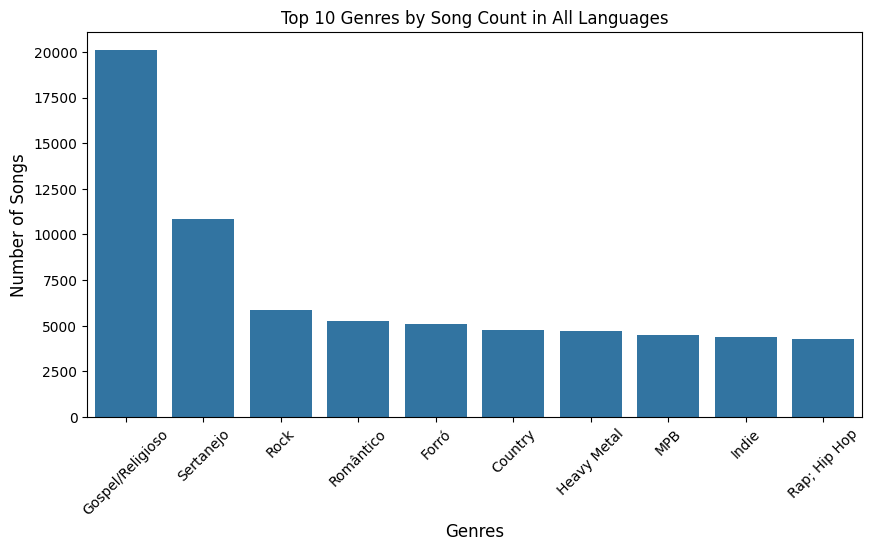

In [16]:
genre_counts = finalDF['Genres'].value_counts()

# Filter to keep only the top 10 genres
top_genres = genre_counts.head(10).index

filteredDF = finalDF[finalDF['Genres'].isin(top_genres)]

# Plotting
plt.figure(figsize=(10,5))
sns.countplot(x='Genres', data=filteredDF, order=top_genres)
plt.title('Top 10 Genres by Song Count in All Languages')
plt.ylabel('Number of Songs', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [17]:
englishDF = finalDF[finalDF['language'] == 'en']
genreLabels = []

for x in englishDF['Genres'].tolist():
    if x == 'Rock':
        y = True
    else:
        y = False
    genreLabels.append(y)
is_rock = np.array(genreLabels)

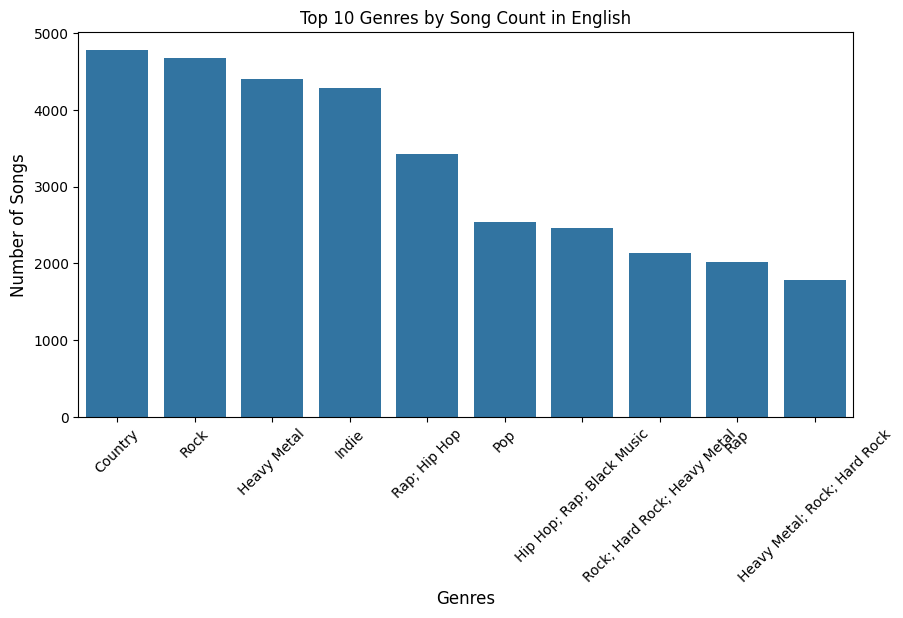

In [18]:
genre_counts = englishDF['Genres'].value_counts()

# Filter to keep only the top 10 genres
top_genres = genre_counts.head(10).index

filteredDF = englishDF[englishDF['Genres'].isin(top_genres)]

# Plotting
plt.figure(figsize=(10,5))
sns.countplot(x='Genres', data=filteredDF, order=top_genres)
plt.title('Top 10 Genres by Song Count in English')
plt.ylabel('Number of Songs', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [19]:
englishArtists = englishDF['Artist'].unique()
englishGenres = englishDF['Genres'].unique()

df = pd.DataFrame(columns=('artist', 'words', 'songcount'))
j=0

tokens =[]
for artist in englishArtists:
    num_words = 0
    lyrics = englishDF['Lyric'][englishDF['Artist'] == artist]
    #print("\nArtist %s" %artist, "Num Lyrics %s" %len(lyrics))
    for lyric in lyrics:
        #print("\nArtist %s" %artist,"Lyric:\n" , lyric)
        words = simple_tokenizer(lyric)
        tokens.append(words)
        num_words = num_words + len(words)
    df.loc[j] = (artist, num_words, len(lyrics))
    j+=1
    i=0

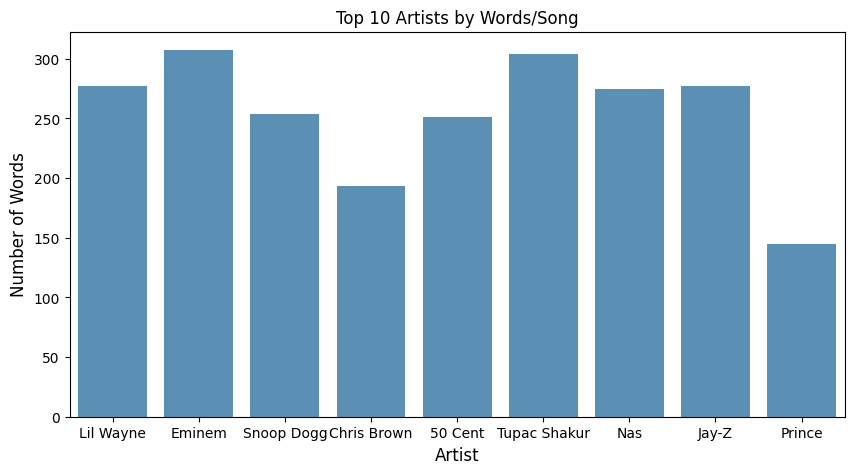

In [20]:
sort_df = df.sort_values('words',ascending=False)
sort_df = sort_df.iloc[0:9,]


plt.figure(figsize=(10,5))
sns.barplot(x=sort_df['artist'], y=(sort_df['words']/sort_df['songcount']), alpha=0.8)
plt.title('Top 10 Artists by Words/Song')
plt.ylabel('Number of Words', fontsize=12)
plt.xlabel('Artist', fontsize=12)
plt.show()

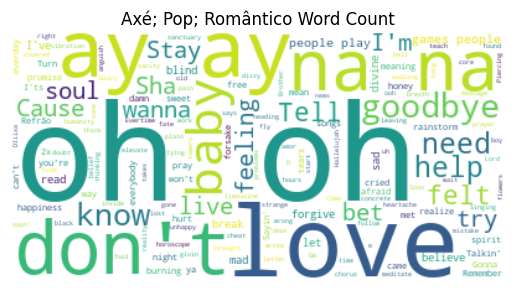

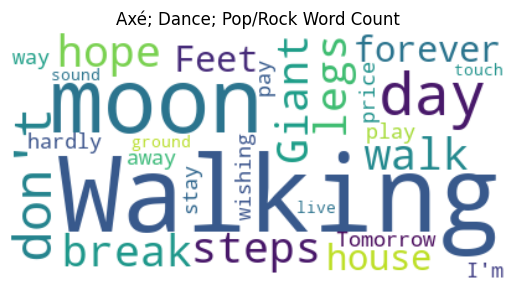

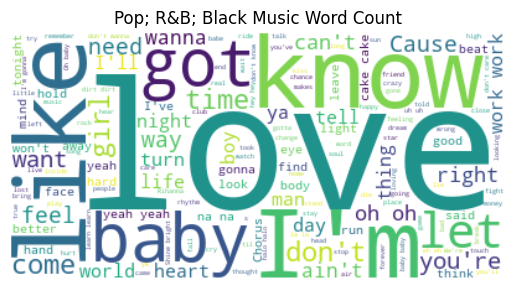

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline



grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)

for i in range(4, 7):
    #plt.subplot(grid[0,i])    #2, 2, i+1)
    lyric = " ".join(lyric for lyric in englishDF[englishDF['Genres']== englishGenres[i]].Lyric)
    wordcloud = WordCloud(stopwords=STOPLIST, background_color="white").generate(lyric)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(englishGenres[i] + " Word Count")
    plt.axis("off")
    plt.show()          

In [22]:
# Print Topics function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [23]:
cv = CountVectorizer(tokenizer=simple_tokenizer, lowercase=False, min_df=0.01, max_df=0.9)
tfidf = TfidfVectorizer(tokenizer=simple_tokenizer, lowercase=False, min_df=0.01, max_df=0.9)

# get vectors
count_vecs = cv.fit_transform(englishDF['Lyric']).toarray()
lyric_features = tfidf.fit_transform(englishDF['Lyric']).toarray()



c:\Users\nikhi\Desktop\SEM III\NLP\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [24]:
def print_topics(model, vectorizer, top_n):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
               for i in topic.argsort()[:-top_n - 1:-1]])

In [25]:
# choose the number of components (topics)
n_topics = 10
n_words = 10

# LDA uses word counts
lda = LatentDirichletAllocation(n_components=n_topics, n_jobs=-1)
lda_lyric_features = lda.fit_transform(count_vecs)

# Print the topics found by the LDA model
print("\n Topics found via LDA:")
print_topics(lda, cv, n_words)


 Topics found via LDA:
Topic 0:
[('night', 35905.84301100678), ('light', 23220.718392032933), ('fire', 23151.416784789963), ('hey', 21356.679064848726), ('world', 15950.319064052193), ('high', 14589.059021865258), ('sky', 13603.343141453779), ('god', 12789.438115849842), ('heaven', 12210.144936754428), ('blood', 11628.224682684287)]
Topic 1:
[('oh', 205296.7433418357), ('yeah', 127308.0407560027), ('baby', 122163.56245892469), ('wanna', 74618.05332636304), ('got', 56426.69019279614), ('know', 47140.615957058726), ('let', 43498.21977767128), ('girl', 43322.30929415892), ('like', 37133.009595349526), ('want', 34507.90660885999)]
Topic 2:
[('life', 70418.9573599649), ('way', 54671.656471320974), ('day', 46926.671792895606), ('let', 45365.8363456681), ('know', 40032.40493786456), ('world', 35175.777817456874), ('time', 33699.10246230963), ('find', 30990.93406158313), ('come', 30121.910837894837), ('live', 27592.465135542967)]
Topic 3:
[('right', 34871.09315427403), ('know', 29101.00728476

In [26]:
# get top x words
top_words = 10

for vectorizer, vecs in [(cv, count_vecs), (tfidf, lyric_features)]:
    for s in [is_rock, ~is_rock]:    
        # sum counts
        s_sum = vecs[s].sum(axis=0)
        # sort arguments
        s_sorted = np.argsort(s_sum)
        # print top words
        print([vectorizer.get_feature_names_out()[x] for x in s_sorted[-top_words:]])


['yeah', 'na', 'come', 'time', 'baby', 'like', 'got', 'oh', 'know', 'love']
['come', 'baby', 'yeah', 'time', 'let', 'oh', 'got', 'know', 'like', 'love']
['away', 'want', 'come', 'time', 'like', 'baby', 'got', 'oh', 'know', 'love']
['yeah', 'want', 'baby', 'let', 'time', 'oh', 'got', 'like', 'know', 'love']


In [27]:
englishDF = finalDF[finalDF['language'] == 'en']

genreLabels = []
count=0
for x in englishDF['Genres'].tolist():
    if x == 'Rock':
        y = 1
        count+=1
    else:
        y = 0
    genreLabels.append(y)

is_rock = np.array(genreLabels)
print(count)

4672


In [29]:
for name in englishDF['Genres'].unique():
    print(name)

Pop; Axé; Romântico
MPB; Axé
Axé
Axé; Romântico; Trilha Sonora
Axé; Pop; Romântico
Axé; Dance; Pop/Rock
Pop; R&B; Black Music
R&B; Pop; Black Music
Hip Hop; Rap; Black Music
R&B; Black Music; Soul Music
Black Music; Soul Music; R&B
Electronica; Black Music; Hip Hop
Romântico; Trilha Sonora; Black Music
Hip Hop; Dance; Pop
Rap; Black Music; Pop
Rap; Hip Hop; Pop
Hip Hop; R&B; Rap
Rap; Pop; Hip Hop
Hip Hop; Black Music; R&B
Dance; Pop; R&B
Black Music; Soul Music; Hip Hop
Black Music; R&B; Hip Hop
Dance; Black Music; Hip Hop
Black Music; Hip Hop; Rap
Rap; Black Music; Hip Hop
Gospel/Religioso; Pop; Black Music
Hip Hop; Pop; R&B
Pop; R&B; Hip Hop
MPB; Samba; Black Music
R&B; Black Music; Rap
Black Music; Rap; Hip Hop
R&B; Black Music; Funk
Gospel/Religioso; Black Music; Soul Music
Hip Hop; R&B; Black Music
Romântico; Black Music
Soul Music; Pop; Disco
Pop; Dance; Hip Hop
Black Music; Romântico; Pop
Black Music; Reggae; Hip Hop
Hip Hop; Black Music; Rap
R&B; Black Music; Pop
Electronica; D

In [21]:
from sklearn.utils import resample
englishDF = finalDF[finalDF['language'] == 'en']

# Create genre labels
genre_mapping = {'Rock': 0, 'Country': 1, 'Indie': 2, 'Rap; Hip Hop':3, 'Pop':4,'Other': 5}
genreLabels = [genre_mapping.get(genre, genre_mapping['Other']) for genre in englishDF['Genres']]

# Convert to numpy array
genreLabels = np.array(genreLabels)

balanced_df = englishDF.copy()
balanced_df['genreLabel'] = genreLabels

# Find the size of the smallest class
min_class_size = min(np.bincount(genreLabels))

# Create a balanced dataset
balanced_data = pd.DataFrame()
for genre in np.unique(genreLabels):
    # Filter the data by each genre
    genre_data = balanced_df[balanced_df['genreLabel'] == genre]
    
    # Resample the data
    genre_sample = resample(genre_data, replace=False, n_samples=min_class_size, random_state=42)
    
    # Append to the balanced dataset
    balanced_data = pd.concat([balanced_data, genre_sample])

# Separate features and labels
X_balanced = balanced_data.drop('genreLabel', axis=1)  # Drop the genre label column
y_balanced = balanced_data['genreLabel']

# Split the balanced dataset
lyrics_train, lyrics_test, genre_train, genre_test = train_test_split(
    X_balanced, y_balanced, random_state=42, test_size=0.3, shuffle=True)

lyrics_train, lyrics_val, genre_train, genre_val = train_test_split(
    lyrics_train, genre_train, random_state=42, test_size=0.2, shuffle=True)

In [22]:
def pad_sequence(seqs, seq_len=200):
    # function for adding padding to ensure all seq same length
    features = np.zeros((len(seqs), seq_len),dtype=int)
    for i, seq in enumerate(seqs):
        if len(seq) != 0:
            features[i, -len(seq):] = np.array(seq)[:seq_len]
    return features

def doc_to_index(docs, vocab):
    # transform docs into series of indices
    docs_idxs = []
    for d in docs:
        w_idxs = []
        for w in d:
            if w in vocab:
                w_idxs.append(vocab[w])
            else:
                # unknown token = 1
                w_idxs.append(1)
        docs_idxs.append(w_idxs)
    return(docs_idxs)

In [23]:
parsed_train = [simple_tokenizer(str(d)) for d in lyrics_train['Lyric']]
parsed_val = [simple_tokenizer(str(d)) for d in lyrics_val['Lyric']]
parsed_test = [simple_tokenizer(str(d)) for d in lyrics_test['Lyric']]

In [25]:
# construct glove weight matrix
# construct vocab
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, ngram_range=(1,1), min_df=0.01, max_df=0.9)
cv.fit(parsed_train)
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))

vocab = dict([(v, vocab[v]+2) for v in vocab])
vocab['_UNK'] = 1
vocab['_PAD'] = 0
glove_vecs = np.zeros(shape=(len(vocab), 300))
for k, v in vocab.items():
    glove_vecs[v] = nlp(k).vector


# additional formatting
idx_train = doc_to_index(parsed_train, vocab)
padded_train = pad_sequence(idx_train)
idx_val = doc_to_index(parsed_val, vocab)
padded_val = pad_sequence(idx_val)
idx_test = doc_to_index(parsed_test, vocab)
padded_test = pad_sequence(idx_test)

c:\Users\nikhi\Desktop\SEM III\NLP\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Size of vocab: 1163


In [26]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

    def forward(self, embeds, hidden):
        # getting the shape information
        batch_size, output_len, dimensions = embeds.size()
        # attention scores
        attention_scores = torch.bmm(embeds, embeds.transpose(1, 2).contiguous())
        attention_scores = attention_scores.view(batch_size * output_len, output_len)
        # normalize
        attention_weights = nn.functional.softmax(attention_scores,dim=1)
        attention_weights = attention_weights.view(batch_size, output_len, output_len)
        # weight hidden layer
        mix = torch.bmm(attention_weights, hidden)
        # output result
        return mix, attention_weights

In [27]:
import torch.nn.functional as F
class SentimentNet(nn.Module):
    def __init__(self, weight_matrix=None, vocab_size=None, output_size=1, hidden_dim=512, embedding_dim=400, n_layers=1, dropout_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding, embedding_dim = self.init_embedding(vocab_size, embedding_dim, weight_matrix)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_size)  
        self.attn = Attention(hidden_dim)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        weighted_out, attention_weights = self.attn(embeds, lstm_out)
        weighted_out = weighted_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(weighted_out)
        out = self.fc(out)
        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1]

        return out, hidden, attention_weights, lstm_out
    def init_embedding(self, vocab_size, embedding_dim, weight_matrix):
        # initializes the embedding
        if weight_matrix is None:
            if vocab_size is None:
                raise ValueError('If no weight matrix, need a vocab size')
            # if embedding is a size, initialize trainable
            return(nn.Embedding(vocab_size, embedding_dim),
                   embedding_dim)
        else:
            # otherwise use matrix as pretrained
            weights = torch.FloatTensor(weight_matrix)
            return(nn.Embedding.from_pretrained(weights),
                  weights.shape[1])
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [29]:
import torch
from torch.utils.data import DataLoader, TensorDataset


train_inputs = torch.tensor(padded_train, dtype=torch.long)

train_labels_np = genre_train.to_numpy()  
train_labels = torch.tensor(train_labels_np, dtype=torch.long) 

# Create TensorDataset
train_data = TensorDataset(train_inputs, train_labels)

# Create DataLoader
batch_size = 32 
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)


In [34]:
num_classes = 6  # Number of classes
num_epochs = 5  # Number of epochs

# Initialize the model
model = SentimentNet(weight_matrix=glove_vecs, vocab_size=len(vocab), output_size=num_classes, hidden_dim=512, embedding_dim=400, n_layers=1, dropout_prob=0.5)
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    total_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
       
        hidden = model.init_hidden(inputs.size(0))

        # Detach hidden states from their history
        hidden = tuple([each.data for each in hidden])

        # Forward pass
        outputs, hidden, _, _ = model(inputs, hidden)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print progress for every 10 batches
        if (i + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {total_loss / (i + 1):.4f}')

c:\Users\nikhi\Desktop\SEM III\NLP\.venv\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/5], Step [50/268], Loss: 1.7630
Epoch [1/5], Step [100/268], Loss: 1.6509
Epoch [1/5], Step [150/268], Loss: 1.6079
Epoch [1/5], Step [200/268], Loss: 1.5775
Epoch [1/5], Step [250/268], Loss: 1.5567
Epoch [2/5], Step [50/268], Loss: 1.4335
Epoch [2/5], Step [100/268], Loss: 1.4217
Epoch [2/5], Step [150/268], Loss: 1.4153
Epoch [2/5], Step [200/268], Loss: 1.4084
Epoch [2/5], Step [250/268], Loss: 1.4087
Epoch [3/5], Step [50/268], Loss: 1.3325
Epoch [3/5], Step [100/268], Loss: 1.3533
Epoch [3/5], Step [150/268], Loss: 1.3367
Epoch [3/5], Step [200/268], Loss: 1.3418
Epoch [3/5], Step [250/268], Loss: 1.3446
Epoch [4/5], Step [50/268], Loss: 1.2501
Epoch [4/5], Step [100/268], Loss: 1.2648
Epoch [4/5], Step [150/268], Loss: 1.2828
Epoch [4/5], Step [200/268], Loss: 1.2905
Epoch [4/5], Step [250/268], Loss: 1.2963
Epoch [5/5], Step [50/268], Loss: 1.2343
Epoch [5/5], Step [100/268], Loss: 1.2389
Epoch [5/5], Step [150/268], Loss: 1.2258
Epoch [5/5], Step [200/268], Loss: 1.23

In [35]:
test_inputs = torch.tensor(padded_test, dtype=torch.long)

test_labels_np = genre_test.to_numpy()  
test_labels = torch.tensor(test_labels_np, dtype=torch.long)  


test_data = TensorDataset(test_inputs, test_labels)

test_batch_size = 32  

test_loader = DataLoader(test_data, shuffle=False, batch_size=test_batch_size)

In [36]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  
        for inputs, labels in test_loader:
            # Forward pass
            outputs, hidden, _, _ = model(inputs, model.init_hidden(inputs.size(0)))
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Convert outputs to predicted class
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy


test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 1.3218, Test Accuracy: 0.4662


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch

def evaluate_metrics(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():  
        for inputs, labels in data_loader:
            outputs, hidden, _, _ = model(inputs, model.init_hidden(inputs.size(0)))
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.tolist())
            predictions.extend(predicted.tolist())

    # Calculate metrics for each class
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average=None)
    recall = recall_score(true_labels, predictions, average=None)
    f1 = f1_score(true_labels, predictions, average=None)
    conf_matrix = confusion_matrix(true_labels, predictions)

    return accuracy, precision, recall, f1, conf_matrix

accuracy, precision, recall, f1, conf_matrix = evaluate_metrics(model, test_loader, criterion)
print(f"Accuracy: {accuracy}\n")
print("Precision by Class:", precision)
print("Recall by Class:", recall)
print("F1 Score by Class:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.4661572052401747

Precision by Class: [0.2834507  0.42757243 0.37712243 0.847981   0.48059701 0.23157895]
Recall by Class: [0.21128609 0.55440415 0.56117021 0.89027431 0.42091503 0.12104539]
F1 Score by Class: [0.24210526 0.48279752 0.45109567 0.86861314 0.44878049 0.15898826]
Confusion Matrix:
 [[161 196 238  10  91  66]
 [120 428 112   7  61  44]
 [109 100 422  10  54  57]
 [  5  13  16 714  23  31]
 [ 76 116 110  47 322  94]
 [ 97 148 221  54 119  88]]


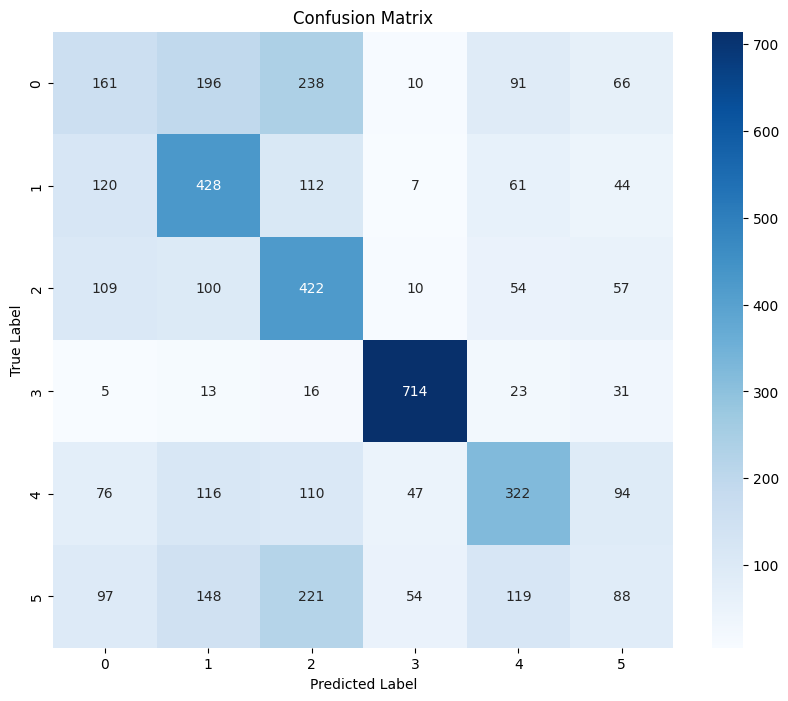

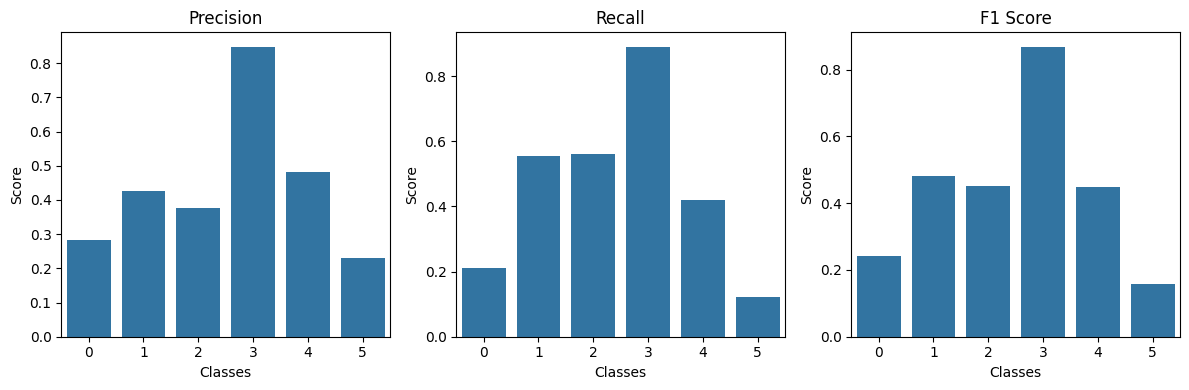

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_metrics(metrics, metric_names):
    plt.figure(figsize=(12, 4))
    for i, (metric, name) in enumerate(zip(metrics, metric_names), 1):
        plt.subplot(1, 3, i)
        sns.barplot(x=np.arange(len(metric)), y=metric)
        plt.title(name)
        plt.xlabel('Classes')
        plt.ylabel('Score')
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(conf_matrix)
plot_metrics([precision, recall, f1], ['Precision', 'Recall', 'F1 Score'])

In [61]:
import dill                          
filename = 'NLP.pkl'
dill.dump_session(filename)# to store the session

In [3]:
import dill
filename = 'NLP.pkl'
dill.load_session(filename) #to load the session up